In [1]:
using Plots
using DifferentialEquations
using Interpolations
using Random
using Distributions
using NLopt
using Dierckx
using LaTeXStrings
using LinearAlgebra
using StatsPlots
using KernelDensity
using Printf
gr();

In [2]:
plot_font = "Computer Modern"
default(fontfamily=plot_font,linewidth=1,framestyle=:box,label=nothing,grid=true)
default(xguidefontsize=10,yguidefontsize=10,xtickfontsize=10,ytickfontsize=10)
default(palette = palette(:Blues))

In [3]:
Tend=500 # final time
k=0.0005 # heat transfer coefficient
Ta=20.0 # ambient temperature
T0=180.0 # initial temperature - known 
σ=8.0 # noise strength
a=zeros(2) # parameter vector
t=LinRange(0,Tend,51)
tt=LinRange(0,Tend,501);

In [4]:
# return the squared model solution
function model_squared(t,T0,a)
    y=zeros(length(t))
    c=1/(a[1]-T0)
    T(t)=(1.0+a[1]*a[2]*t-c*a[1])/(a[2]*t-c)
    for i in 1:length(t) 
        y[i] = T(t[i])
    end 
    return y
end;

In [5]:
# create the data
data=model_squared(t,T0,[Ta,k])+[0; σ*randn(length(t)-1)]
# plot the data
p1=scatter(t,data,mc=4,msc=:match,label=false)
# plot the model solution
p1=plot!(tt,model_squared(tt,T0,[Ta,k]),color=5,lw=2)
p1=plot!(xlabel=L"t",ylabel=L"T(t)",xlims=(t[1]-5,t[end]+5),ylims=(0,200),
    xticks=([0,100,200,300,400,500],[L"0", L"100", L"200", L"300", L"400", L"500"]),
    yticks=([0,50,100,150,200],[L"0", L"50", L"100", L"150",L"200"]),label=false);

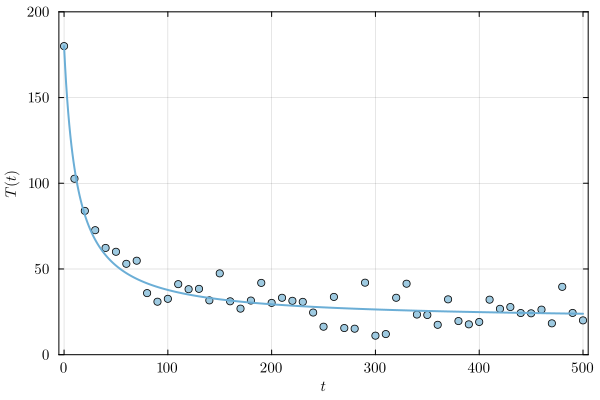

In [6]:
display(p1)

In [7]:
# compute the loglikelihood
function loglhood(data,T0,a,σ)
    y=zeros(length(t))
    y=model_squared(t,T0,a)
    e=0
    dist=Normal(0,σ)
    e=loglikelihood(dist,data-y) 
    return sum(e)
end;

In [8]:
# find the MLE
function Optimise(fun,θ₀,lb,ub)    
    tomax=(θ,∂θ)->fun(θ)
    opt=Opt(:LN_NELDERMEAD,length(θ₀))
    opt.max_objective=tomax
    opt.lower_bounds=lb      
    opt.upper_bounds=ub
    opt.maxtime=1*60
    res = optimize(opt,θ₀)
    return res[[2,1]]
end;

Tamin=0.0
Tamax=1000.0
kmin=0.0
kmax=1000.0

θG=[20,0.05]
lb=[Tamin,kmin]
ub=[Tamax,kmax];

In [9]:
# compute the mle
function funmle(a)
    return loglhood(data,T0,a,σ)
end;
@time (xopt,fopt)=Optimise(funmle,θG,lb,ub)
Tamle=xopt[1]
kmle=xopt[2]
Tmle(t)=xopt[1]+(T0-xopt[1])*exp(-xopt[2]*t)
@printf("MLE: Ta = %0.5f, k = %0.5f \n",Tamle,kmle)

  0.088549 seconds (437.11 k allocations: 24.726 MiB, 8.59% gc time, 97.82% compilation time)
MLE: Ta = 19.73980, k = 0.00046 


In [10]:
# calculate the posterior using MCMC
@time begin

    # number of MCMC chains to generate
    number_chains=4

    # parameters of the perturbation kernel
    mu_perturbation=[0.0; 0.0]
    sigma_perturbation=[5.0e-1 0.0; 0.0 5.0e-8]

    # initialise chain variables
    max_iterations=100000 # total number of iterations
    check_iteration=10000 # how often to check for convergence
    truncate_iterations=5000 # burn in - number to discard
    Ta_chain=zeros(Float64,max_iterations,number_chains)
    Ta_chain_truncated=zeros(Float64,max_iterations-truncate_iterations,number_chains)
    k_chain=zeros(Float64,max_iterations,number_chains)
    k_chain_truncated=zeros(Float64,max_iterations-truncate_iterations,number_chains)
    loglhd=zeros(Float64,max_iterations,number_chains)
    model_data_error=zeros(Float64,max_iterations,number_chains)

    # initialise the chains at the MLE
    Ta_chain[1,1:4]=Tamle*ones(1,4)
    k_chain[1,1:4]=kmle*ones(1,4)

    # calculate the loglikelihood
    global ii=1
    for jj=1:number_chains
        loglhd[ii,jj]=loglhood(data,T0,[Ta_chain[ii,jj],k_chain[ii,jj]],σ)
    end

    while ii<max_iterations
        
        global ii=ii+1
        global jj=1
        
        while jj<=number_chains   
            # perturb the parameters - ensure they don't go negative
            rr=rand(MvNormal(mu_perturbation,sigma_perturbation))
            Ta_chain[ii,jj]=abs(Ta_chain[ii-1,jj]+rr[1,1]);
            k_chain[ii,jj]=max(k_chain[ii-1,jj]+rr[2,1],0);
            # calculate the loglikelihood
            loglhd[ii,jj]=loglhood(data,T0,[Ta_chain[ii,jj],k_chain[ii,jj]],σ)
            # evaluate acceptance probability
            lhd_ratio=exp(loglhd[ii,jj]-loglhd[ii-1,jj])
            alpha=min(1.0,lhd_ratio)
            # decide whether to accept the new parameters
            rr=rand(1)
            if rr[1]>alpha 
                # don't accept the move - rewind the chain
                Ta_chain[ii,jj]=Ta_chain[ii-1,jj]
                k_chain[ii,jj]=k_chain[ii-1,jj]
            end
            global jj=jj+1   
        end
        
        # check chain convergence
        if mod(ii,check_iteration)==0 && (ii>check_iteration)
            @printf("Using %05i samples \n",ii-truncate_iterations)
            Ta_chain_truncated=Ta_chain[truncate_iterations+1:ii,:]     
            n_data_Ta=size(Ta_chain_truncated,1)
            within_chain_variance_Ta=var(Ta_chain_truncated,dims=1)
            within_chain_mean_ta=mean(Ta_chain_truncated,dims=1)
            W_Ta=mean(within_chain_variance_Ta)
            total_mean_Ta=mean(within_chain_mean_ta)
            B_Ta=n_data_Ta*norm(within_chain_mean_ta.-total_mean_Ta,2)^2/(number_chains-1)
            Rhat_Ta=sqrt((W_Ta-W_Ta/n_data_Ta+B_Ta/n_data_Ta)/W_Ta)
            @printf("Gelmans convergence statistic: T_a %0.5f \n",Rhat_Ta)
            k_chain_truncated=k_chain[truncate_iterations+1:ii,:]
            n_data_k=size(k_chain_truncated,1)
            within_chain_variance_k=var(k_chain_truncated,dims=1)
            within_chain_mean_k=mean(k_chain_truncated,dims=1)
            W_k=mean(within_chain_variance_k)
            total_mean_k=mean(within_chain_mean_k)
            B_k=n_data_k*norm(within_chain_mean_k.-total_mean_k,2)^2/(number_chains-1)
            Rhat_k=sqrt((W_k-W_k/n_data_k+B_k/n_data_k)/W_k)
            @printf("Gelmans convergence statistic: k %0.5f \n",Rhat_k)
        end
        
    end
    
end

Using 15000 samples 
Gelmans convergence statistic: T_a 1.01694 
Gelmans convergence statistic: k 1.00627 
Using 25000 samples 
Gelmans convergence statistic: T_a 1.00351 
Gelmans convergence statistic: k 1.00183 
Using 35000 samples 
Gelmans convergence statistic: T_a 1.00524 
Gelmans convergence statistic: k 1.00194 
Using 45000 samples 
Gelmans convergence statistic: T_a 1.00689 
Gelmans convergence statistic: k 1.00310 
Using 55000 samples 
Gelmans convergence statistic: T_a 1.00680 
Gelmans convergence statistic: k 1.00250 
Using 65000 samples 
Gelmans convergence statistic: T_a 1.00910 
Gelmans convergence statistic: k 1.00281 
Using 75000 samples 
Gelmans convergence statistic: T_a 1.00739 
Gelmans convergence statistic: k 1.00222 
Using 85000 samples 
Gelmans convergence statistic: T_a 1.00687 
Gelmans convergence statistic: k 1.00192 
Using 95000 samples 
Gelmans convergence statistic: T_a 1.00563 
Gelmans convergence statistic: k 1.00150 
  0.896887 seconds (13.97 M allocatio

In [11]:
# plot sample of Ta chains
p11=plot(Ta_chain_truncated[1:5000,:],lc=[6 5 4 3])
p11=plot!(xlabel="Number of iterations",ylabel=L"T_a",xlims=(0,5000),ylims=(0,40),
    xticks=([0,2500,5000],[L"0", L"2500", L"5000"]),
    yticks=([0,10,20,30,40,50],[L"0", L"10", L"20", L"30",L"40",L"50"]),legend=false)
# plot sample of k chains
p12=plot(k_chain_truncated[1:5000,:],lc=[6 5 4 3])
p12=plot!(xlabel="Number of iterations",ylabel=L"k",xlims=(0,5000),ylims=(0,0.0025),
    xticks=([0,2500,5000],[L"0", L"2500", L"5000"]),
    yticks=([0.000,0.0005,0.0010,0.0015,0.0020,0.0025],[L"0.0000",L"0.0005",L"0.0010",L"0.0015",L"0.0020",L"0.0025"]),legend=false);

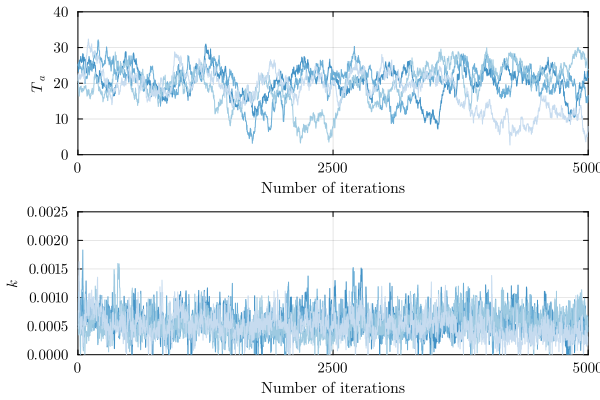

In [12]:
p1=plot(p11,p12,layout=(2,1))

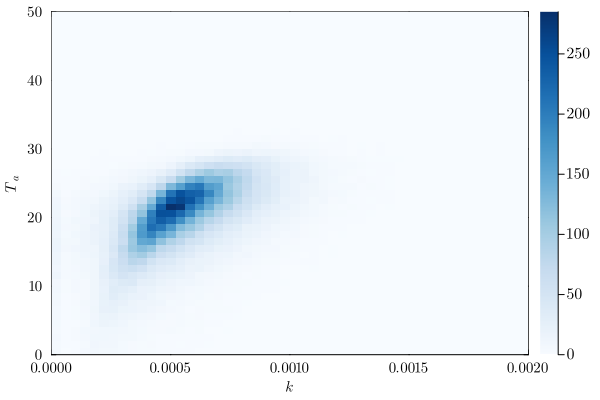

In [13]:
k_chain_reshaped=reshape(k_chain_truncated,(1,number_chains*(max_iterations-truncate_iterations)))
Ta_chain_reshaped=reshape(Ta_chain_truncated,(1,number_chains*(max_iterations-truncate_iterations)))
p2=histogram2d(k_chain_reshaped[:],Ta_chain_reshaped[:],
    bins=(range(0,0.002,length=51),range(0,50,length=51)),show_empty_bins=true,normalize=:pdf,color=:Blues)
p2=plot!(xlims=(0,0.002),ylims=(0,50),xlabel=L"k",ylabel=L"T_a",
    xticks=([0.000,0.0005,0.0010,0.0015,0.0020],[L"0.0000",L"0.0005",L"0.0010",L"0.0015",L"0.0020"]),
    yticks=([0,10,20,30,40,50],[L"0", L"10", L"20", L"30",L"40",L"50"]),legend=false)
display(p2)

In [14]:
p31=histogram(Ta_chain_reshaped[:],bins=(range(0,40,length=51)),show_empty_bins=true,color=:Blues,normalize=:pdf)
p31=plot!(xlims=(0,40),ylims=(0,0.1),xlabel=L"T_a",
    yticks=([0.00,0.025,0.05,0.075,0.1],[L"0.000", L"0.025", L"0.050", L"0.075",L"0.010"]),
    xticks=([0,10,20,30,40,50],[L"0", L"10", L"20", L"30",L"40",L"50"]),legend=false)
p32=histogram(k_chain_reshaped[:],bins=(range(0,0.002,length=51)),show_empty_bins=true,color=:Blues,normalize=:pdf)
p32=plot!(xlims=(0,0.002),ylims=(0,2500),xlabel=L"k",
    xticks=([0,0.0005,0.0010,0.0015,0.0020],[L"0.0000",L"0.0005",L"0.0010",L"0.0015",L"0.0020"]),
    yticks=([0,500,1000,1500,2000,2500],[L"0", L"500", L"1000", L"1500",L"2000",L"2500"]),legend=false);

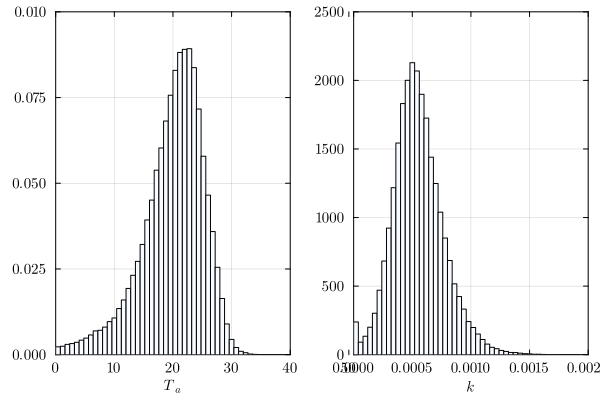

In [20]:
p3=plot(p31,p32,layout=(1,2))

In [19]:
# calculate the prediction intervals using samples from the posterior
# take a random sample from the chains
number_samples=100;
pi_samples=rand(1:length(k_chain_reshaped),1,number_samples)

lower=1000*ones(length(tt));
upper=zeros(length(tt))
for ii=1:number_samples
    c=1/(Ta_chain_reshaped[pi_samples[ii]]-T0)
    Ts(t)=(1.0+Ta_chain_reshaped[pi_samples[ii]]*k_chain_reshaped[pi_samples[ii]]*t-c*Ta_chain_reshaped[pi_samples[ii]])/(k_chain_reshaped[pi_samples[ii]]*t-c)
    for jj=1:length(tt)
        if Ts(tt[jj])+quantile(Normal(0,σ),[0.05,0.95])[1] < lower[jj] 
            lower[jj] = Ts(tt[jj])+quantile(Normal(0,σ),[0.05,0.95])[1]
        end
        if Ts(tt[jj])+quantile(Normal(0,σ),[0.05,0.95])[2] > upper[jj] 
            upper[jj] = Ts(tt[jj])+quantile(Normal(0,σ),[0.05,0.95])[2] 
        end   
    end
end

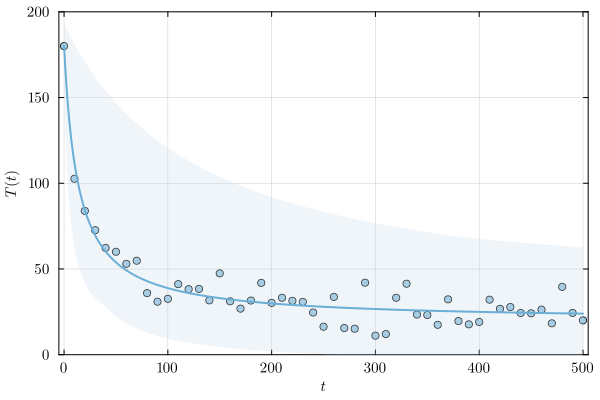

In [17]:
p4=scatter(t,data,mc=4,msc=:match,label=false)
p4=plot!(tt,lower,lw=0,fillrange=upper,fillalpha=0.25,color=3,label=false,xlims=(tt[1]-1,tt[end]+1),ylims=(0,200))
p4=plot!(tt,model_squared(tt,T0,[Tamle,kmle]),color=5,lw=2)
p4=plot!(xlabel=L"t",ylabel=L"T(t)",xlims=(t[1]-5,t[end]+5),ylims=(0,200),
    xticks=([0,100,200,300,400,500],[L"0", L"100", L"200", L"300", L"400", L"500"]),
    yticks=([0,50,100,150,200],[L"0", L"50", L"100", L"150",L"200"]),label=false)
display(p4)